<a href="https://colab.research.google.com/github/assalahalla/Django-onlinecourse-final-project/blob/master/GAN_str_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
try:
    from google.colab import drive
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [14]:
# HIDE OUTPUT

#!{CMD}
!pip install -r "./sample_data/requirements.txt"
!pip install tabgan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scipy-1.4.1-cp37-cp37m-manylinux1_x86_64.whl (26.1 MB)
  Using cached category_encoders-2.1.0-py2.py3-none-any.whl (100 kB)
ERROR: Could not find a version that satisfies the requirement numpy==1.22.0 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0rc1, 1.13.0rc2, 1.13.0, 1.13.1, 1.13.3, 1.14.0rc1, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0rc1, 1.15.0rc2, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0rc1, 1.16.0rc2, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0rc1, 1.17.0rc2, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0rc1, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0rc1, 1.19.0rc2, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5, 1.20.0rc1, 1

redémarrez le runtime pour pouvoir utiliser les versions nouvellement installées.

# **Chargement de données**

Nous allons commencer par générer de fausses données. La bibliothèque tabgan peut générer des données catégorielles (textuelles) et continues (numériques).

La bibliothèque tabgan nécessite la trame de données Pandas pour s'entraîner. Pour cette raison, nous conservons les valeurs Pandas et Numpy.

In [15]:
# HIDE OUTPUT
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd
import io
import os
import requests
import numpy as np
from sklearn import metrics
import json

with open('./sample_data/schema.json', 'r') as f :
  datajs = json.load(f)

df = pd.DataFrame(datajs)

COLS_USED = ['cylinders', 'displacement', 'horsepower', 'weight', 
          'acceleration', 'year', 'origin','mpg']
COLS_TRAIN = ['cylinders', 'displacement', 'horsepower', 'weight', 
          'acceleration', 'year', 'origin']

df = df[COLS_USED]

# Handle missing value
df['horsepower'] = df['horsepower'].fillna(df['horsepower'].median())


# Split into training and test sets
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(
    df.drop("mpg", axis=1),
    df["mpg"],
    test_size=0.20,
    #shuffle=False,
    random_state=42,
)

# Create dataframe versions for tabular GAN
df_x_test, df_y_test = df_x_test.reset_index(drop=True), \
  df_y_test.reset_index(drop=True)
df_y_train = pd.DataFrame(df_y_train)
df_y_test = pd.DataFrame(df_y_test)

# Pandas to Numpy
x_train = df_x_train.values
x_test = df_x_test.values
y_train = df_y_train.values
y_test = df_y_test.values

# Build the neural network
model = Sequential()
# Hidden 1
model.add(Dense(50, input_dim=x_train.shape[1], activation='relu')) 
model.add(Dense(25, activation='relu')) # Hidden 2
model.add(Dense(12, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)
model.fit(x_train,y_train,validation_data=(x_test,y_test),
        callbacks=[monitor], verbose=2,epochs=1000)

Epoch 1/1000
10/10 - 1s - loss: 5144.5527 - val_loss: 1406.7267 - 623ms/epoch - 62ms/step
Epoch 2/1000
10/10 - 0s - loss: 592.5632 - val_loss: 135.2202 - 51ms/epoch - 5ms/step
Epoch 3/1000
10/10 - 0s - loss: 197.6022 - val_loss: 291.4925 - 44ms/epoch - 4ms/step
Epoch 4/1000
10/10 - 0s - loss: 269.8840 - val_loss: 198.3270 - 45ms/epoch - 5ms/step
Epoch 5/1000
10/10 - 0s - loss: 165.1499 - val_loss: 132.7745 - 46ms/epoch - 5ms/step
Epoch 6/1000
10/10 - 0s - loss: 149.7560 - val_loss: 139.5689 - 43ms/epoch - 4ms/step
Epoch 7/1000
10/10 - 0s - loss: 149.6281 - val_loss: 131.5892 - 44ms/epoch - 4ms/step
Epoch 8/1000
10/10 - 0s - loss: 142.9001 - val_loss: 129.5952 - 53ms/epoch - 5ms/step
Epoch 9/1000
10/10 - 0s - loss: 140.8780 - val_loss: 127.9815 - 44ms/epoch - 4ms/step
Epoch 10/1000
10/10 - 0s - loss: 139.1093 - val_loss: 126.3786 - 45ms/epoch - 4ms/step
Epoch 11/1000
10/10 - 0s - loss: 138.4400 - val_loss: 125.8120 - 47ms/epoch - 5ms/step
Epoch 12/1000
10/10 - 0s - loss: 137.7067 - val_

Nous évaluons maintenant le réseau neuronal formé pour voir le RMSE. Nous utiliserons ce réseau de neurones formé pour comparer la précision entre les données d'origine et les données générées par le GAN.

---

Si un réseau de neurones formé sur des données originales ne fonctionne pas bien sur de nouvelles données, alors les nouvelles données peuvent être suspectes ou fausses.


In [16]:
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 5.507496251343306


# **Training du GAN**

Ensuite, nous allons entraîner le GAN à générer de fausses données à partir des données d'origine. Il existe de nombreuses options que vous pouvez affiner pour le GAN. L'exemple présenté ici utilise la plupart des valeurs par défaut. Ce sont les hyperparamètres habituels qui doivent être réglés pour n'importe quel modèle et nécessitent une certaine expérimentation pour des résultats optimaux.


In [17]:
from tabgan.sampler import GANGenerator
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

gen_x, gen_y = GANGenerator(gen_x_times=1.1, cat_cols=None,
           bot_filter_quantile=0.001, top_filter_quantile=0.999, \
              is_post_process=True,
           adversarial_model_params={
               "metrics": "rmse", "max_depth": 2, "max_bin": 100, 
               "learning_rate": 0.02, "random_state": \
                42, "n_estimators": 500,
           }, pregeneration_frac=2, only_generated_data=False,\
           gan_params = {"batch_size": 500, "patience": 25, \
          "epochs" : 500,}).generate_data_pipe(df_x_train, df_y_train,\
          df_x_test, deep_copy=True, only_adversarial=False, \
          use_adversarial=True)



Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]


# **Évaluation des résultats du GAN**

nous pouvons voir que les données générées par le GAN ressemblent à l'original. Certaines valeurs, généralement des nombres entiers dans les données d'origine, ont des valeurs fractionnaires dans les données synthétiques.


In [18]:
gen_x

,cylinders,displacement,horsepower,weight,acceleration,year,origin
0,4,181.560380,82.238300,2467,13.333533,76,3
1,4,134.000000,95.000000,2560,14.200000,78,3
2,4,241.758229,72.301703,2455,14.874459,78,2
3,4,404.312365,155.194728,2409,10.939271,78,2
4,4,134.000000,95.000000,2515,14.800000,78,3
...,...,...,...,...,...,...,...
455,8,429.000000,208.000000,4633,11.000000,72,1
456,8,350.000000,155.000000,4502,13.500000,72,1
457,8,360.000000,175.000000,3821,11.000000,73,1
458,8,350.000000,160.000000,4456,13.500000,72,1


In [19]:
print(gen_x.iloc[:].to_json(orient="records", indent = 5))

[
     {
          "cylinders":4,
          "displacement":181.560380425,
          "horsepower":82.2382998158,
          "weight":2467,
          "acceleration":13.3335331362,
          "year":76,
          "origin":3
     },
     {
          "cylinders":4,
          "displacement":134.0,
          "horsepower":95.0,
          "weight":2560,
          "acceleration":14.2,
          "year":78,
          "origin":3
     },
     {
          "cylinders":4,
          "displacement":241.7582290207,
          "horsepower":72.3017027567,
          "weight":2455,
          "acceleration":14.8744592429,
          "year":78,
          "origin":2
     },
     {
          "cylinders":4,
          "displacement":404.3123645454,
          "horsepower":155.1947284835,
          "weight":2409,
          "acceleration":10.9392709751,
          "year":78,
          "origin":2
     },
     {
          "cylinders":4,
          "displacement":134.0,
          "horsepower":95.0,
          "weight":2515,
   

In [20]:
gen_x.iloc[:].to_json('json_gen.json', orient="records", indent = 5)

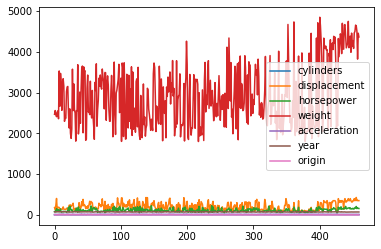

In [21]:
gen_x.plot()

In [22]:
# Predict
pred = model.predict(gen_x.values)
score = np.sqrt(metrics.mean_squared_error(pred,gen_y.values))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 11.396094592438846
